## Kalman Filters for Generator Model 1
#### Madhusudhan Pandey, with modification by Bernt Lie
#### University of South-Eastern Norway
#### Spring of 2019

#### **Packages and definitions**

##### Packages

In [25]:
# Introducing packages
using DataFrames
using CSV
using Plots; pyplot()
using LaTeXStrings
#using JLD
using LinearAlgebra
using NLsolve
using Statistics
#using DifferentialEquations
#using Compat, Random, Distributions

##### Definitions

In [26]:
figpath = "C:/Users/Bernt_Lie/OneDrive/Documents/researchUSN/Supervisor/MScThesis/Spring2019/Madhusudhan_Pandey/figs/"
# Linewidths and styles
LW1 = 2 
LW2 = 1.5
LS1 = :solid
LS2 = :dot
LS3 = :dashdot
LS4 = :dash
#
# markershape=:x, markersize=4, markeralpha=1.0, markercolor=:maroon
# markerstrokewidth=1, markerstrokealpha=1.0, markerstrokecolor=:maroon, markerstrokestyle=:solid
MK1 =(:x,4,1.0,:maroon,stroke(1,1.0,:maroon,:solid));

#### **Data from Aabjøra generator**
#### Importing data

In [27]:
df=CSV.read("realdata.csv")
#load If, It, Twc
df_input = df[70:653, [:Column6, :Column13, :Column11 ]]
df_output = df[70:653, [:Column7, :Column8]]
df_water_temp = df[70:653, [:Column10, :Column9]]
If_s, It_s, Twc_s = df_input[1],df_input[2],df_input[3]
Ts_meas_s, TFe_meas_s = df_output[1], df_output[2]
Tac_s, Tah_s = df_water_temp[1],df_water_temp[2]
# All data are vectors of strings and missing, so converting
# it back to float64
#
# N measurement data are used
N = 584
# ny number of outputs: Ts, TFe
ny = 2
# nu number of inputs: Twc, If, It
nu = 3
#
If,It,Twc,Ts_m,TFe_m =zeros(N),zeros(N),zeros(N),zeros(N),zeros(N)
Tac_m, Tah_m = zeros(N), zeros(N)
for i in range(1,step=1,N)
    If[i]=parse(Float64, If_s[i])
    It[i]=parse(Float64, It_s[i])
    Twc[i]=parse(Float64, Twc_s[i])
    Ts_m[i]=parse(Float64, Ts_meas_s[i])
    TFe_m[i]=parse(Float64, TFe_meas_s[i])
    Tac_m[i]=parse(Float64, Tac_s[i])
    Tah_m[i]=parse(Float64, Tah_s[i])
end

#### Storing measurements

In [28]:
y_m = [[Ts_m[i],TFe_m[i]] for i in 1:N];

#### Presenting experimental data

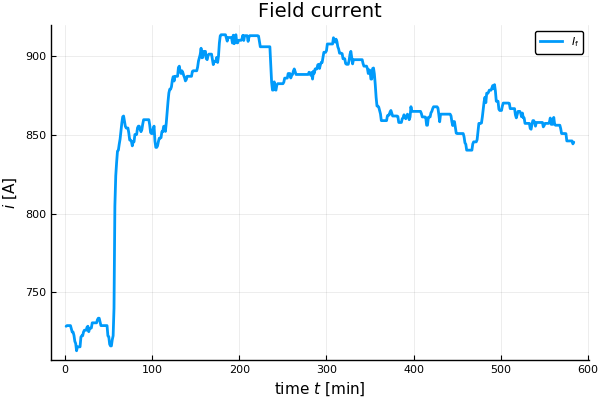

In [29]:
plot(If,lw=LW1,label=L"I_\mathrm{f}")
plot!(xlabel=L"time $t$ [min]", ylabel=L"$i$ [A]",title="Field current")

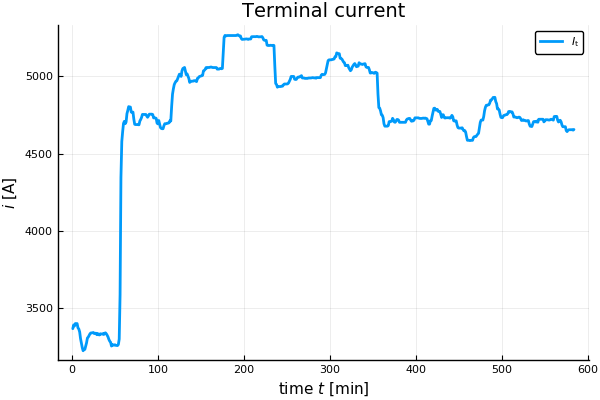

In [30]:
plot(It,lw=LW1,label=L"I_\mathrm{t}")
plot!(xlabel=L"time $t$ [min]", ylabel=L"$i$ [A]", title="Terminal current")

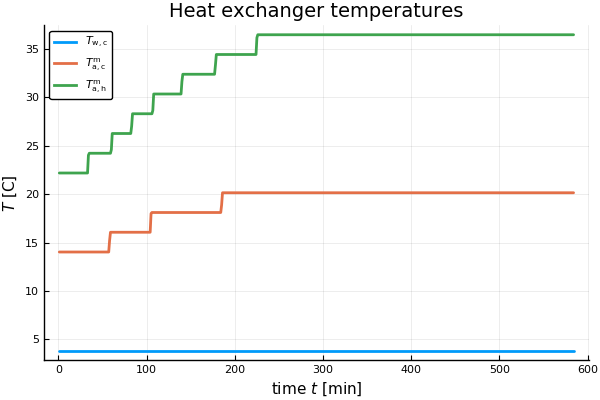

In [31]:
plot(Twc,lw=LW1,label=L"T_\mathrm{w,c}")
plot!(Tac_m,lw=LW1,label=L"T_\mathrm{a,c}^\mathrm{m}")
plot!(Tah_m,lw=LW1,label=L"T_\mathrm{a,h}^\mathrm{m}")
plot!(xlabel=L"time $t$ [min]", ylabel=L"$T$ [C]", title="Heat exchanger temperatures")

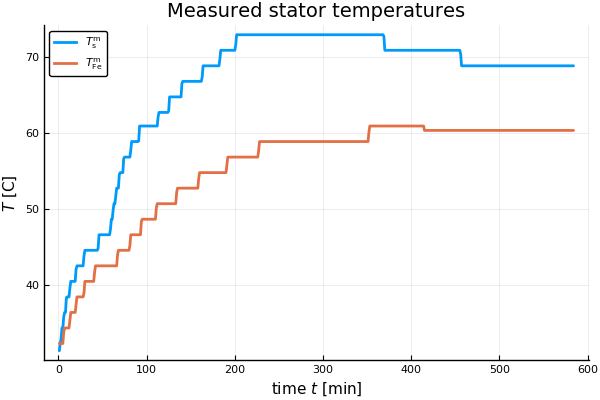

In [32]:
plot(Ts_m,lw=LW1,label=L"T_\mathrm{s}^\mathrm{m}")
plot!(TFe_m,lw=LW1,label=L"T_\mathrm{Fe}^\mathrm{m}")
plot!(xlabel=L"time $t$ [min]", ylabel=L"$T$ [C]", title="Measured stator temperatures")

#### **Simulation model**
#### Inputs

In [33]:
# If, imported from CSV file
# It, imported from CSV file
# Twc, imported from CSV file
QdFes = 212.
Wdf = 528.
Qdfs = 0.8*Wdf # Efficient heating in air gap due to friction
mdw = 48.51
mda = 44.28;

#### Parameters

In [34]:
pa = 1.01e5 # Atmospheric pressure , Pa
#
# Heat capacities
chpa = 1.012#1.15 # Specific heat capacity air , kJ.kg-1.K-1  
chpw = 4.1813#4.2 # Specific heat capacity water , kJ.kg-1.K-1 
chpCu = 0.385#0.385 # Specific heat capacity copper , kJ.kg-1.K -1 
chpFe = 0.412#0.465 # Specific heat capacity iron , kJ.kg-1.K-1 
#
# Metal massses
mr = 9260. # Mass of copper in rotor , kg
ms = 6827. # Mass of copper in stator , kg
mFe = 71200. # Mass of iron in stator , kg
#
# Specific volumes (inverse of density)
VhCu = 0.112e-3 # Specific volume of copper , m3/kg 
VhFe = 0.127e-3 # Specific volume of iron , m3/kg 
#
# Resulting volumes
Vr = mr*VhCu # Rotor copper volume , m3  
Vs = ms*VhCu # Stator copper volume , m3 
VFe = mFe*VhFe # Stator iron volume , m3 
#
# Heat transfer (heat transfer coefficient x area), fluids to solid
hAax = 55.6 # Heat transfer from air to solid, kW/K
hAwx = 222. # Heat transfer from water to solid, kW/K
#
# Overall heat transfer (overall heat transfer coeffcients x area)
UAx = 1/(1/hAax+1/hAwx) # Overall heat transfer air-to-water, kW/K
UAr2d = 2.96 #2.835  #2.7 # Heat transfer, rotor copper to air gap, kW/K 
UAs2Fe = 18 #19.#20. # Heat transfer, stator copper to stator iron, kW/K 
UAFe2a = 12.87 #13.585 # 14.285 # 14.3 # Heat transfer, rotor iron to hot air, kW/K 
#
# Stanton numbers for heat exchanger
NSta = UAx/chpa/(mda)
NStw = UAx/chpw/(mdw)
NStd = NStw - NSta
#
# Enthalpies of formation
Hha_o = 0. # Enthalpy of formation air, kJ/kg
HhCu_o = 0. # Enthalpy of formation copper, kJ/kg 
HhFe_o = 0. # Enthalpy of formation iron, kJ/kg
#
# Standard state temperatures
Ta_o = 25. # Standard state temperature air, C
TCu_o = 25. # Standard state temperature copper, C
TFe_o = 25. # Standard state temperature iron, C
#
# Copper conductor resistances
Rr = 0.127e-3 # Ohmic resistance, rotor copper, kOhm, at 25 C
Rs = 1.95e-6  # Ohmic resistance, stator copper, kOhm, at 25 C
#
# Vector of parameters
par = [pa,chpa,chpw,chpCu,chpFe,mr,ms,mFe,VhCu,VhFe,
    Vr,Vs,VFe,UAr2d,UAs2Fe,UAFe2a,Hha_o,HhCu_o,
    HhFe_o,Ta_o,TCu_o,TFe_o,Rr,Rs,Qdfs,hAax,hAwx,UAx,NStw,NSta,NStd];

#### Models
##### Algebraic variables

In [35]:
# Given x_k = (Tr,Ts,TFe) at time index k,
# this function returns z_k = (Tac,Tad,Tah) at time index k
function z_k(x_k,k)
    Tr,Ts,TFe = x_k
    function f!(F, z)
        Tac,Tad,Tah = z[1], z[2], z[3]
        F[1] = mda*chpa*(Tac-Tad)+UAr2d*(Tr-Tad)+Qdfs
        F[2] = mda*chpa*(Tad-Tah)+UAFe2a*(TFe-Tah)
        F[3] = Tac*(NStw-NSta*exp(-NStd))-NStd*Tah-NSta*(1-exp(-NStd))*Twc[k]
    end
    return nlsolve(f!,[Ta_o,Ta_o,Ta_o]).zero   
end

z_k (generic function with 1 method)

##### One step ahead state predictor

In [36]:
# Given x_k = (Tr,Ts,TFe) at time index k, z_k = (Tac,Tad,Tah) at time index k
# and wx_k at time index k, this function returns x_kp1 at time index k+1
#
# Sample time for measurements
dt = 60 # Discretization time, s
#
# Number nx of states x; number nz of algebraic variables nz
nx = 3
nz = 3
#
# Prediktor, using Explicit Euler
function x_kp1(x_k,z_k,wx_k,k)
    Tr,Ts,TFe = x_k
    Tac,Tad,Tah = z_k
    wTr,wTs,wTFe = wx_k
    #
    # Vector fields
    fTr = (1.1*Rr*If[k]^2-UAr2d*(Tr-Tad))/(mr*chpCu)
    fTs = (3*Rs*It[k]^2-UAs2Fe*(Ts-TFe))/(ms*chpCu)
    fTFe = (UAs2Fe*(Ts-TFe)-UAFe2a*(TFe-Tah)+QdFes)/(mFe*chpFe)
    #
    # Euler integration + addition of discrete state disturbance
    Tr = Tr + dt*fTr + wTr
    Ts = Ts + dt*fTs + wTs
    TFe = TFe + dt*fTFe + wTFe
    return [Tr,Ts,TFe]
end

x_kp1 (generic function with 1 method)

##### Outputs and Output Subsampling Indices

In [37]:
# Given x_k = (Tr,Ts,TFe), compute output y_k = (Ts,TFe)
function y_k(x_k)
    return x_k[[2,3]]
end
#
# Subsampling of outputs
idx = 1:10:N;

#### **Statistical description: state disturbance, noise, and initial value**

In [38]:
#
# Statistical description of state disturbance, measurement noise, and initial state
#
# Process state disturbance covariance W and Process state disturbance standard deviation sW
W = diagm(0=>[2^2,2^2,2^2])
sW = sqrt(W)
#
# Measurement noise covariance V and Measurement noise standard deviation sV
V = diagm(0 => [1^2,1^2])
sV = sqrt(V)
#
# Initial state
x1 = [28.,Ts_m[1],TFe_m[1]]
#
# Initial state covariance X1 and Initial state standard deviation sX1
#
mux = 10;
X1 = mux*W
sX1 = sqrt(X1);

#### **Ensemble Kalman Filter**
#### Storage arrays and Initialization

#### Ensemble Kalman Filter

In [39]:
#particle=Numbers of ensemble members
function EnKF(particles)
    np=particles
    #np = 10
    # Initialization
    XX_pr = zeros(nx,N,np) # Priori particles
    XX_po = zeros(nx,N,np) # Posteriori particles
    ZZ = zeros(nz,N,np) # Best (posteriori) algebraic particles 
    YY_pr = zeros(ny,N,np) # Priori output particles
    #
    # Initialization for covariance residue
    cov_residue = zeros(ny,ny,N)
    # Initialization
    #
    # Drawing initial state for particles
    XX_po[:,1,:] = kron(x1,ones(1,np)) + sX1*randn(nx,np)
    XX_pr = XX_po
    #
    # Computing initial algebraic variables for particles
    ZZ[:,1,:] = reduce(hcat,[z_k(XX_po[:,1,p],1) for p in 1:np])
    #
    # Computing initial noisy outputs for particles
    YY_pr[:,1,:] = reduce(hcat,[y_k(XX_pr[:,1,p]) for p in 1:np]) + sV*randn(ny,np);
    cov_residue[:,:,1] = cov(YY_pr[:,1,:], dims=2)
    for k in 2:N
        #
        # Predicting states for every particle
        for p in 1:np
            XX_pr[:,k,p] = x_kp1(XX_po[:,k-1,p],ZZ[:,k-1,p],sW*randn(nx),k-1)
        end
        # Predicting outputs for every particle
        YY_pr[:,k,:] = reduce(hcat,[y_k(XX_pr[:,k,p]) for p in 1:np]) + sV*randn(ny,np);
        # Computing Kalman gain
        Z = cov(XX_pr[:,k,:],YY_pr[:,k,:],dims=2)
        E = cov(YY_pr[:,k,:],dims=2)
        K = Z/E
        # Computing posteriori particles
        for p in 1:np
            XX_po[:,k,p] = XX_pr[:,k,p] + K*(y_m[k]- YY_pr[:,k,p])
        end
        # Updating cov_residue
        cov_residue[:,:,k] = E
        # Updating algebraic variables for every particle
        ZZ[:,k,:] = reduce(hcat,[z_k(XX_po[:,k,p],k) for p in 1:np])
    end 
    # Mean and standard deviations of quantities
    x_pr = mean(XX_pr,dims=3)[:,:,1]
    x_pr_s = std(XX_pr,dims=3)[:,:,1]
    x_po = mean(XX_po,dims=3)[:,:,1]
    x_po_s = std(XX_po,dims=3)[:,:,1]
    z = mean(ZZ,dims=3)[:,:,1]
    z_s = std(ZZ,dims=3)[:,:,1]
    y_pr = mean(YY_pr,dims=3)[:,:,1];
    y_pr_s = std(YY_pr,dims=3)[:,:,1];
    return [x_pr,x_pr_s,x_po,x_po_s,z,y_pr,cov_residue]
end

EnKF (generic function with 1 method)

In [ ]:
# Coparing simulation time Running 50 times for
particles=(10,50,100,1000)
Nruntime=50
e=zeros(length(particles),Nruntime)
E=zeros(length(particles),Nruntime)
time=zeros(length(particles),Nruntime)
for (index,value) in enumerate(particles)
    for i in 1:Nruntime
        time[index,i]=@elapsed EnKF(value)
        x_po,z,y_pr,cov_residue=EnKF(value)
        e[index,i]=sqrt(sum((y_pr'-hcat(y_m...)').^2)/N)
        E[index,i]=sqrt(sum(cov_residue.^2.)/N)
    end
end
mean(time,dims=2)
mean(e,dims=2)
mean(E,dims=2)

#### **Unscented Kalman Filter**
#### Utility functions

In [42]:
# Function to convert mean x + covariance matrix X, dim(X) = nx*nx, into matrix of sigma points sigX, dim(sigX) = nx*nz
function sigma_points(x,X;nsig=0,α=1e-3,κ=0,β=2)
    sx = size(x)
    sX = size(X)
    nx = sx[1]
    if (length(sx)==1) && (length(sX)==2) && (sX[1]==sX[2]==nx)
        if nsig==0
            sigX = Matrix{Float64}(undef,nx,2nx)
            X_ = cholesky(nx*Hermitian(X)).U
            sigX[:,1:nx] = x .+ X_
            sigX[:,nx+1:2nx] = x .- X_
            return sigX,1
        else
            sigX = Matrix{Float64}(undef,nx,2nx+1)
            λ = α^2*(nx+κ)-nx
            X_ = cholesky((nx+λ)*Hermitian(X)).U
            sigX[:,1] = x
            sigX[:,2:nx+1] = x .+ X_
            sigX[:,nx+2:2nx+1] = x .- X_
            #
            ζ_m0 = λ/(nx+λ)
            ζ_c0 = ζ_m0 + (1 - α^2 + β)
            ζ_i = 1/(2nx+2λ)
            return sigX,[ζ_m0,ζ_c0,ζ_i]
        end
    else
        return "Incorrect input data"
    end
end    
#
# Function to compute weighted average and covariance for sigma points
function sigma_statistics(sigX,ζ)
    nzeta = length(ζ)
    if nzeta == 1
        nx = size(sigX,1)
        x_ = mean(sigX,dims=2)
        X = cov(sigX,dims=2,corrected=false)
    else
        ns = size(sigX,2)
        ζ_m0 = ζ[1]
        ζ_c0 = ζ[2]
        ζ_i = ζ[3]
        #
        x_ = ζ_m0*sigX[:,1] + (ns-1)*ζ_i*mean(sigX[:,2:end],dims=2) 
        X = ζ_c0*(sigX[:,1]-x_)*(sigX[:,1]-x_)' + (ns-1)*ζ_i*cov(sigX[:,2:end].-x_,dims=2,corrected=false)
    end
    X = Hermitian(X)
    return x_,X
end

sigma_statistics (generic function with 1 method)

$\bar{y} = \sum_i \zeta_i^{m} y_i$, while $Y = \sum_i \zeta_i^{c} (y_i - \bar{y})(y_i - \bar{y})^T$

#### 1. UKF type (sigma points, type of noise)

In [43]:
# nsig=0 implies 2*nx sigma points; nsig<>1 implies 2*nx+1 sigma points
#nsig = 0
# noise_map=0 implies assuming linear, additive noise; noise_map<>0 removes assumption of linear noise map
#noise_map= 0;
function UKF_Type(nsig, noise_map)
    # Initialization
    # N measurement data, nx states, nz algebraic variables, ny measurements
    xu_pr = zeros(nx,N) # Priori states
    xu_po = zeros(nx,N) # Posteriori states
    zu = zeros(nz,N) # Best (posteriori) algebraic values 
    yu_pr = zeros(ny,N) # Priori output values
    #
    # Standard deviation
    xu_pr_s = zeros(nx,N) # Priori state std
    xu_po_s = zeros(nx,N) # Posteriori states std
    zu_s = zeros(nz,N) # Best (posteriori) algebraic value std 
    yu_pr_s = zeros(ny,N) # Priori output value std
    #
     # Initialization for covariance residue
    cov_residue = zeros(ny,ny,N)
    # Sigma matrices
    if nsig == 0
        if noise_map == 0
            ns = 2nx
        else
            ns = 4nx+2ny
        end
    else
        if noise_map == 0
            ns = 2nx+1
        else
            ns = 4nx+2ny+1
        end
    end
    XXu_po = zeros(nx,ns)
    ZZu = zeros(nz,ns)
    XXu_pr = zeros(nx,ns)
    XXu_pr_y = zeros(nx,ns)
    YYu_pr = zeros(ny,ns)
    #
    # Initialization
    #
    xu_po[:,1] = x1;
    xu_pr[:,1] = x1;
    zu[:,1] = z_k(x1,1)
    yu_pr[:,1] = y_k(x1);
    #
    xu_po_s[:,1] = diag(sqrt(X1))
    xu_pr_s[:,1] = xu_po_s[:,1];
    cov_residue[:,:,1] = [0 0;0 0]
    ##
    # Implementing UKF
    # Initializing current (k-1) posteriori covariance matrix
    X_po = X1;
    #
    # noise_map = 0
    if noise_map == 0
        # Loops over data
        for k in 2:N
            #
            # Finding sigma points XXu_po for index k-1
            XXu_po,zeta = sigma_points(xu_po[:,k-1],X_po;nsig=nsig) 
            ns = size(XXu_po,2)
            #
            # Finding sigma points ZZu for index k-1
            for i in 1:ns
                ZZu[:,i] = z_k(XXu_po[:,i],k-1)
            end
            # Finding z covariance Z_po at k-1
            _, Z_po = sigma_statistics(ZZu,zeta)
            ez_min = minimum(eigvals(Z_po))
            # ...make sure that the smallest eigenvalue is at least +1e-6
            Z_po = Z_po + max(-ez_min-1e-6,1e-6)*I
            #
            # Predicting sigma states XXu_pr
            for i in 1:ns
                wx = zeros(3)
                XXu_pr[:,i] = x_kp1(XXu_po[:,i],ZZu[:,i],wx,k-1)
            end
            # Predicting state mean xu_pr and Covariance X_pr
            x_,X_ = sigma_statistics(XXu_pr,zeta)
            xu_pr[:,k] = x_
            X_pr = X_ + W 
            #
            # Predicting sigma outputs YYu_pr
            for i in 1:ns
                YYu_pr[:,i] = y_k(XXu_pr[:,i])
            end
            # Predicting output mean yu_pr over sigma values
            y_,Y_ = sigma_statistics(YYu_pr,zeta)
            yu_pr[:,k] = y_
            E = Y_ + V
            #
            # Covariance residue
            cov_residue[:,:,k]=E
            # Computing Kalman gain
            Z = cov(XXu_pr,YYu_pr,dims=2,corrected=false)
            K = Z/E
            #
            # Computing posterior values
            xu_po[:,k] = xu_pr[:,k] + K*(y_m[k] - yu_pr[:,k])
            zu[:,k] = z_k(xu_po[:,k],k)
            #
            # Computing posterior covariance
            X_po = X_pr - K*E*K'
            # Computing standard deviations
            xu_pr_s[:,k] = diag(sqrt(X_pr))
            xu_po_s[:,k] = diag(sqrt(X_po))
            yu_pr_s[:,k] = diag(sqrt(E))
            zu_s[:,k] = diag(sqrt(Z_po))
        end
        #
        # noise_map <> 0
        #
    else
        # Loops over data
        for k in 2:N
            #
            # Finding sigma points for index k-1
            wx = zeros(3)
            v = zeros(2)
            m_ = vcat(xu_po[:,k-1],wx,v)
            M = cat(X_po,W,V,dims=(1,2))
            sigM,zeta = sigma_points(m_,M;nsig=nsig)
            ns = size(sigM,2)
            XXu_po = sigM[1:nx,:]
            WW = sigM[nx+1:2nx,:]
            VV = sigM[2nx+1:end,:]
            #
            # Finding sigma points ZZu for index k-1
            for i in 1:ns
                ZZu[:,i] = z_k(XXu_po[:,i],k-1)
            end
            # Finding z covariance Z_po at k-1
            _, Z_po = sigma_statistics(ZZu,zeta)
            ez_min = minimum(eigvals(Z_po))
            Z_po = Z_po + max(-ez_min-1e-6,1e-6)*I
            #
            # Predicting sigma states XXu_pr
            for i in 1:ns
                XXu_pr[:,i] = x_kp1(XXu_po[:,i],ZZu[:,i],WW[:,i],k-1)
            end
            # Predicting state mean xu_pr and Covariance X_pr
            x_,X_ = sigma_statistics(XXu_pr,zeta)
            xu_pr[:,k] = x_
            X_pr = X_
            #
            # Predicting sigma outputs YYu_pr
            for i in 1:ns
                YYu_pr[:,i] = y_k(XXu_pr[:,i]) + VV[:,i]
            end
            # Predicting output mean yu_pr over sigma values
            y_,Y_ = sigma_statistics(YYu_pr,zeta)
            yu_pr[:,k] = y_
            E = Y_
            #
            # Covariance residue
            cov_residue[:,:,k]=E
            # Computing Kalman gain
            Z = cov(XXu_pr,YYu_pr,dims=2,corrected=false)
            K = Z/E
            #
            # Computing posterior values
            xu_po[:,k] = xu_pr[:,k] + K*(y_m[k] - yu_pr[:,k])
            zu[:,k] = z_k(xu_po[:,k],k)
            #
            # Computing posterior covariance
            X_po = X_pr - K*E*K'
            # Computing standard deviations
            xu_pr_s[:,k] = diag(sqrt(X_pr))
            xu_po_s[:,k] = diag(sqrt(X_po))
            yu_pr_s[:,k] = diag(sqrt(E))
            zu_s[:,k] = diag(sqrt(Z_po))
        end
        #
    end
    return xu_pr,xu_po,zu,yu_pr,cov_residue
end

UKF_Type (generic function with 1 method)

In [46]:
# Calling Ensemble Kalam filters
xu_po_EnKF50,zu_EnKF50,yu_pr_EnKF50,cov_residue_EnKF50=EnKF(50)
xu_po_EnKF100,zu_EnKF100,yu_pr_EnKF100,cov_residue_EnKF100=EnKF(100)
xu_po_EnKF500,zu_EnKF500,yu_pr_EnKF500,cov_residue_EnKF500=EnKF(500)
xu_po_EnKF1000,zu_EnKF1000,yu_pr_EnKF1000,cov_residue_EnKF1000=EnKF(1000);
# Calling UKF
xu_po_UKF,zu_UKF,yu_pr_UKF,cov_residue_UKF=UKF_Type(0,0);

In [234]:
Model1UKFEnKF=[xu_po_UKF,zu_UKF,yu_pr_UKF,cov_residue_UKF,xu_po_EnKF50,zu_EnKF50,yu_pr_EnKF50,cov_residue_EnKF50,
xu_po_EnKF100,zu_EnKF100,yu_pr_EnKF100,cov_residue_EnKF100,
xu_po_EnKF500,zu_EnKF500,yu_pr_EnKF500,cov_residue_EnKF500,
xu_po_EnKF1000,zu_EnKF1000,yu_pr_EnKF1000,cov_residue_EnKF1000]

# Saving Model 1 for plotting and comparing
# Saves .jld file in same directory
using JLD
save("Model1UKFEnKF.jld","Model1UKFEnKF",Model1UKFEnKF)

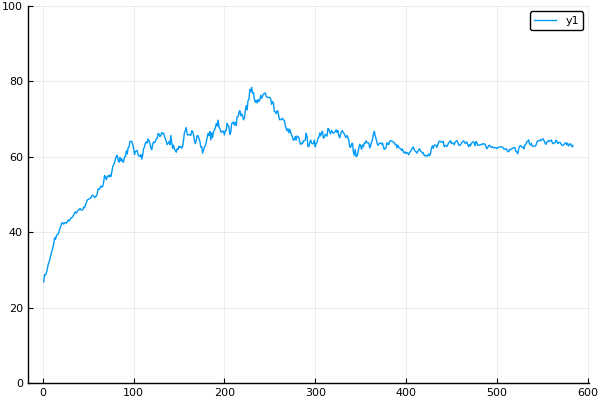

In [232]:
# Load in from the same directory
Model1UKFEnKF=load("Model1UKFEnKF.jld")
# Unpacking dicitionary
xu_po_EnKF50Model1,zu_EnKF50Model1,yu_pr_EnKF50Model1,cov_residue_EnKF50Model1,
xu_po_EnKF100Model1,zu_EnKF100Model1,yu_pr_EnKF100Model1,cov_residue_EnKF100Model1,
xu_po_EnKF500Model1,zu_EnKF500Model1,yu_pr_EnKF500Model1,cov_residue_EnKF500Model1,
xu_po_EnKF1000Model1,zu_EnKF1000Model1,yu_pr_EnKF1000Model1,cov_residue_EnKF1000Model1=Model1UKFEnKF["Model1UKFEnKF"]

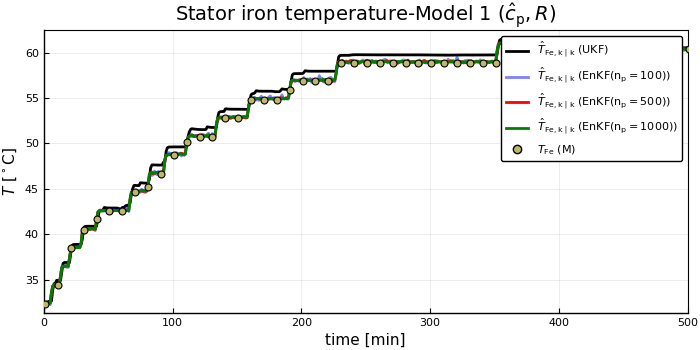

In [47]:
# Air and metal temperatures estimates
# Tr estimate
plt=plot()
plot!(plt,xu_po_UKF[1,:],label=L"\hatT_\mathrm{r,k\mid k}\ \mathrm{(UKF)}",lc=:black,lw=2,ls=:solid)
#plot!(plt,xu_po_EnKF50[1,:],label=L"\hatT_\mathrm{r}\ \mathrm{(EnKF50)}",lc=:blue,la=0.5,lw=2,ls=:solid)
plot!(plt,xu_po_EnKF100[1,:],label=L"\hatT_\mathrm{r,k\mid k}\ \mathrm{(EnKF(n_p=100))}",lc=:blue,la=0.5,lw=2,ls=:solid)
plot!(plt,xu_po_EnKF500[1,:],label=L"\hatT_\mathrm{r,k\mid k}\ \mathrm{(EnKF(n_p=500))}",lc=:red,lw=2,ls=:solid)
plot!(plt,xu_po_EnKF1000[1,:],label=L"\hatT_\mathrm{r,k\mid k}\ \mathrm{(EnKF(n_p=1000))}",lc=:green,la=1,lw=2,ls=:solid)
Trestimate=plot!(plt,xlim=(0,500),size=(700,350),framestyle=:box,title="Rotor copper temperature-Model 1 (\$\\hatc_\\mathrm{p},R\$)",legend=:topright,xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]")
# Ts estimate
plt=plot()
plot!(plt,xu_po_UKF[2,:],label=L"\hatT_\mathrm{s,k\mid k}\ \mathrm{(UKF)}",lc=:black,lw=2,ls=:solid)
#plot!(plt,xu_po_EnKF50[2,:],label=L"\hatT_\mathrm{s}\ \mathrm{(EnKF50)}",lc=:blue,la=0.5,lw=2,ls=:solid)
plot!(plt,xu_po_EnKF100[2,:],label=L"\hatT_\mathrm{s,k\mid k}\ \mathrm{(EnKF(n_p=100))}",lc=:blue,la=0.5,lw=2,ls=:solid)
plot!(plt,xu_po_EnKF500[2,:],label=L"\hatT_\mathrm{s,k\mid k}\ \mathrm{(EnKF(n_p=500))}",lc=:red,lw=2,ls=:solid)
plot!(plt,xu_po_EnKF1000[2,:],label=L"\hatT_\mathrm{s,k\mid k}\ \mathrm{(EnKF(n_p=1000))}",lc=:green,la=1,lw=2,ls=:solid)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
Tsestimate=plot!(plt,xlim=(0,500),size=(700,350),framestyle=:box,title="Stator copper temperature-Model 1 (\$\\hatc_\\mathrm{p},R\$)",legend=:topright,xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]")
# TFe estimate
plt=plot()
plot!(plt,xu_po_UKF[3,:],label=L"\hatT_\mathrm{Fe,k\mid k}\ \mathrm{(UKF)}",lc=:black,lw=2,ls=:solid)
#plot!(plt,xu_po_EnKF50[3,:],label=L"\hatT_\mathrm{Fe}\ \mathrm{(EnKF50)}",lc=:blue,la=0.5,lw=2,ls=:solid)
plot!(plt,xu_po_EnKF100[3,:],label=L"\hatT_\mathrm{Fe,k\mid k}\ \mathrm{(EnKF(n_p=100))}",lc=:blue,la=0.5,lw=2,ls=:solid)
plot!(plt,xu_po_EnKF500[3,:],label=L"\hatT_\mathrm{Fe,k\mid k}\ \mathrm{(EnKF(n_p=500))}",lc=:red,lw=2,ls=:solid)
plot!(plt,xu_po_EnKF1000[3,:],label=L"\hatT_\mathrm{Fe,k\mid k}\ \mathrm{(EnKF(n_p=1000))}",lc=:green,la=1,lw=2,ls=:solid)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkkhaki, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")
TFeestimate=plot!(plt,xlim=(0,500),size=(700,350),framestyle=:box,title="Stator iron temperature-Model 1 (\$\\hatc_\\mathrm{p},R\$)",legend=:topright,xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]")


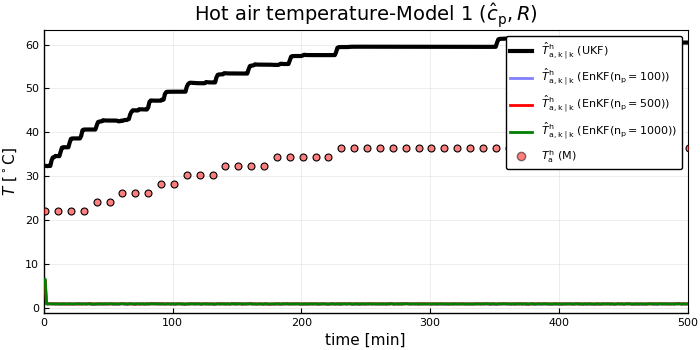

In [48]:
# Air Temperatures
# Tac
plt=plot()
plot!(plt,zu_UKF[1,:],label=L"\hatT_\mathrm{a,k\mid k}^\mathrm{c}\ \mathrm{(UKF)}",lc=:black,lw=2,ls=:solid)
plot!(plt,zu_EnKF100[1,:],label=L"\hatT_\mathrm{a,k\mid k}^\mathrm{c}\ \mathrm{(EnKF(n_p=100))}",lc=:blue,la=0.5,lw=2,ls=:solid)
plot!(plt,zu_EnKF500[1,:],label=L"\hatT_\mathrm{a,k\mid k}^\mathrm{c}\ \mathrm{(EnKF(n_p=500))}",lc=:red,lw=2,ls=:solid)
plot!(plt,zu_EnKF1000[1,:],label=L"\hatT_\mathrm{a,k\mid k}^\mathrm{c}\ \mathrm{(EnKF(n_p=1000))}",lc=:green,la=1,lw=2,ls=:solid)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")
Tacestimate=plot!(plt,xlim=(0,500),size=(700,350),framestyle=:box,title="Cooled air temperature-Model 1 (\$\\hatc_\\mathrm{p},R\$)",legend=:topright,xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]")
# Tad
plt=plot()
plot!(plt,zu_UKF[2,:],label=L"\hatT_\mathrm{a,k\mid k}^\mathrm{\delta}\ \mathrm{(UKF)}",lc=:black,lw=2,ls=:solid)
plot!(plt,zu_EnKF100[2,:],label=L"\hatT_\mathrm{a,k\mid k}^\mathrm{\delta}\ \mathrm{(EnKF(n_p=100))}",lc=:blue,la=0.5,lw=2,ls=:solid)
plot!(plt,zu_EnKF500[2,:],label=L"\hatT_\mathrm{a,k\mid k}^\mathrm{\delta}\ \mathrm{(EnKF(n_p=500))}",lc=:red,lw=2,ls=:solid)
plot!(plt,zu_EnKF1000[2,:],label=L"\hatT_\mathrm{a,k\mid k}^\mathrm{\delta}\ \mathrm{(EnKF(n_p=1000))}",lc=:green,la=1,lw=2,ls=:solid)
Tadestimate=plot!(plt,xlim=(0,500),size=(700,350),framestyle=:box,title="Air gap temperature-Model 1 (\$\\hatc_\\mathrm{p},R\$)",legend=:topright,xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]")
# Tah
plt=plot()
plot!(plt,zu_UKF[3,:],label=L"\hatT_\mathrm{a,k\mid k}^\mathrm{h}\ \mathrm{(UKF)}",lc=:black,lw=3,ls=:solid)
plot!(plt,zu_EnKF100[3,:],label=L"\hatT_\mathrm{a,k\mid k}^\mathrm{h}\ \mathrm{(EnKF(n_p=100))}",lc=:blue,la=0.5,lw=2,ls=:solid)
plot!(plt,zu_EnKF500[3,:],label=L"\hatT_\mathrm{a,k\mid k}^\mathrm{h}\ \mathrm{(EnKF(n_p=500))}",lc=:red,lw=2,ls=:solid)
plot!(plt,zu_EnKF1000[3,:],label=L"\hatT_\mathrm{a,k\mid k}^\mathrm{h}\ \mathrm{(EnKF(n_p=1000))}",lc=:green,la=1,lw=2,ls=:solid)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")
Tahestimate=plot!(plt,xlim=(0,500),size=(700,350),framestyle=:box,title="Hot air temperature-Model 1 (\$\\hatc_\\mathrm{p},R\$)",legend=:topright,xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]")



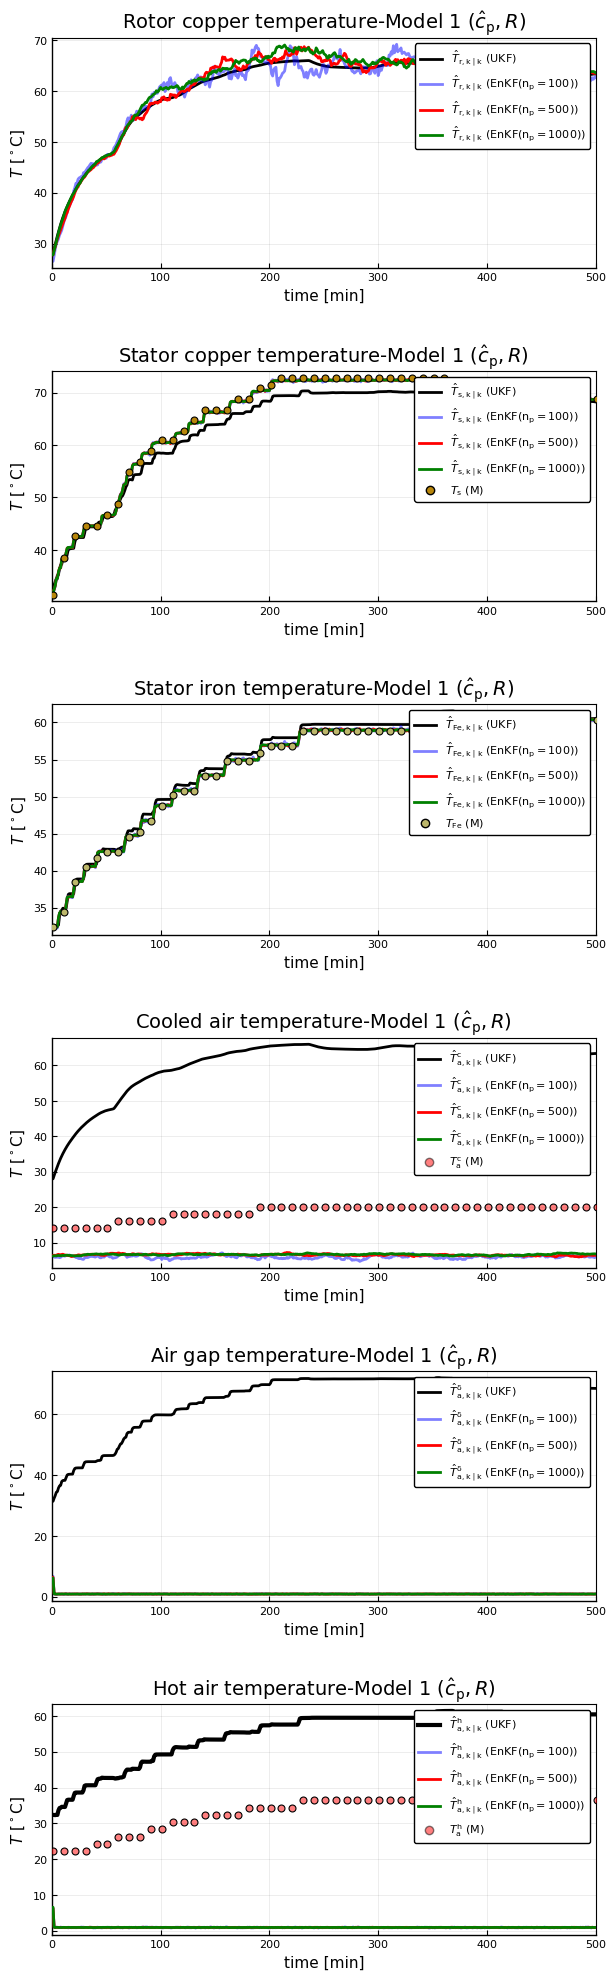

In [49]:
# Plotting for SIMS paper
figpath = "C:/Users/pande/Desktop/Desktop/Thesis/ThesisLyx/figures/chapter8/";
using Plots.PlotMeasures
pyplot();
measured_data=plot(Trestimate, Tsestimate, TFeestimate, Tacestimate,
    Tadestimate, Tahestimate,
        layout=grid(6,1),size = (600, 2000),framestyle = :box,
        bottom_margin=10mm,legend=:topright)
figfile="Model1UKFEKFestimate.svg"
savefig(figpath*figfile)

In [378]:
# Computing computational time
time_model1=zeros(5)
time_model1[1]=@elapsed UKF_Type(0,0)
time_model1[2]=@elapsed EnKF(50)
time_model1[3]=@elapsed EnKF(100)
time_model1[4]=@elapsed EnKF(500)
time_model1[5]=@elapsed EnKF(1000)
print(time_model1)

[0.338137, 1.08818, 2.21127, 10.8608, 26.3431]